### Librerias 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ModuleNotFoundError: No module named 'matplotlib'

### Librerias para interactuar con R

In [2]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects import r


from rpy2.robjects.conversion import localconverter

### Convertidor DataFrame R a Pandas

In [3]:
def dset(datasetr):
    x=r(datasetr)
    with localconverter(ro.default_converter + pandas2ri.converter):
        pd_from_r_df = ro.conversion.rpy2py(x)
        return pd_from_r_df

### Dataset

In [4]:
r('library(aplore3)')

'aplore3','tools','stats',...,'datasets','methods','base'


# 1. Introducción al modelo de regresión logistica

El analisis de regresión es una de las herramientas principales del analisis de datos. Frecuentemente la variable respuesta es discreta, en este caso la herramienta mas usadas es la regresión logistica. Al igual que en otros modelos de regresión, la idea es ajustar el mejor y mas parsimonioso modelo.
Encontrar el mejor ajuste parsimonioso, modelo interpretable que describa la relación entre los input (variables independientes o predictoras) y los output (variables dependientes o respuesta). Las variables independientes son frecuentemente llamadas covariates. Una diferencia entre la regresión lineal y la regresión logistica es que la variable respuesta es binaria. Esta diferencia se refleja en la forma del modelo y en los supuestos. 

## Ejemplo: 

En el libro vemos el dataset CHDAGE el cual contiene la edad, el grupo etario y si tiene riesgo o no de enfermedad cardiaca.

In [5]:
CHDAGE = dset('chdage')

In [6]:
CHDAGE.head(5)

,id,age,agegrp,chd
1,1,20,20-39,No
2,2,23,20-39,No
3,3,24,20-39,No
4,4,25,20-39,No
5,5,25,20-39,Yes


In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
labelencoder = LabelEncoder()
CHDAGE["chd"]=labelencoder.fit_transform(CHDAGE["chd"])
CHDAGE["agegrp"]=labelencoder.fit_transform(CHDAGE["agegrp"])+1

In [9]:
CHDAGE.head(5)

,id,age,agegrp,chd
1,1,20,1,0
2,2,23,1,0
3,3,24,1,0
4,4,25,1,0
5,5,25,1,1


Text(0, 0.5, 'Coronary heart disease')

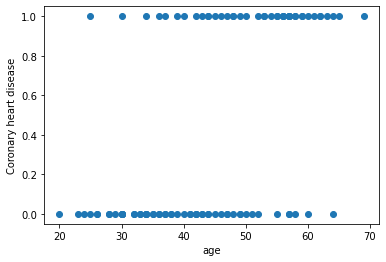

In [10]:
fig, ax = plt.subplots()
ax.scatter(CHDAGE["age"],CHDAGE["chd"])
ax.set_xlabel("age")
ax.set_ylabel("Coronary heart disease")

Notemos que plotear edad vs chd no aporta información valiosa, no vemos con claridad una relación entre las variables

Para remover la variación de los datos podemos agrupar las edades y calcular el promedio. De esta forma empieza a verse una relación. Al aumentar la edad aumentan las probabilidades de enfermedad cardiaca

In [11]:
CHDAGE_gby = CHDAGE[["age","chd","agegrp"]].groupby("agegrp").agg('mean')

Text(0, 0.5, 'Coronary heart disease (mean)')

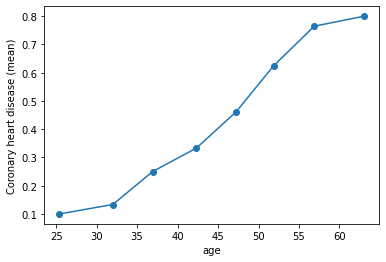

In [12]:
fig, ax = plt.subplots()
ax.plot(CHDAGE_gby["age"],CHDAGE_gby["chd"],'-o')
ax.set_xlabel("age")
ax.set_ylabel("Coronary heart disease (mean)")

Notemos que estamos estimando $\mathbb{E}(Y|x)$. La curva tiene forma de S y se comporta como una distribución acumulada. Esta distribución acumulada esta basada en la distribución logistica.
Existen muchas distribuciones con variable dependiente binaria (vease Cox and Snell (1989)). Sin embargo la distribución logistica es simple y flexible, ademas de ser un modelo interpretable. 


## Distribución logistica

$$\pi(x) = \mathbb{E}(Y|x) = \frac{e^{\beta_0+\beta_1x}}{1+e^{\beta_0+\beta_1x}}$$

Notemos que a diferencia de la distribución normal, en donde escribimos

$$y = \mathbb{E}(Y|x) +\epsilon$$

y asumimos que $\epsilon \sim \mathcal{N}(0,\sigma) $ y se concluye que $Y|x$ distribuye normal con media $\mathbb{E}(Y|x)$ y varianza constante. En la regresión logistica los errores no pueden distribuir normal, pues tienen dos valores posibles. Notemos que escribimos

$$y = \pi(x) + \epsilon$$

Entonces $\epsilon = y-\pi(x)$. Si $y=1$ entonces $\epsilon = 1-\pi(x)$ con probabilidad $\pi(x)$ y si $y=0$ entonces $\epsilon = -\pi(x)$ con probabilidad $1-\pi(x)$
 
Por lo tanto $Y|x$ sigue una distribución binomial con media $\pi(x)$

## 1.2 Ajustando la regresión logística

Tenemos $n$ observaciones independientes de el par $(x_i,y_i)$. Donde $y_i$ toma dos valores (la presencia o la ausencia de una caracteristica), diremos que toma el valor 0 o 1. 
A diferencia de la regresión lineal, la cual se puede ajustar mediante minimos cuadrados y se obtiene un numero deseable de propiedades, esto no pasa con la logistica. Por lo que la forma de ajustar la regresión es mediante el maximum likelihood.

$$L(\mathbb{\beta}) = \prod_{i=1}^n \pi(x_i)^{y_i}(1-\pi(x_i))^{1-y_i} $$

$$LogL(\mathbb{\beta}) = \sum_{i=1}^n  y_i log(\pi(x_i) + (1-y_i)log(1-\pi(x_i))$$

Al derivar e igualar a 0 obtenemos las siguientes ecuaciones

$$\sum_{i=1}^n y_i - \pi(x_i) = 0$$

$$\sum_{i=1}^n (y_i - \pi(x_i))x_i = 0$$

Las ecuaciones obtenidas son no lineales en $\beta_0$ y $\beta_1$, por lo que para resolverlas necesitaremos metodos iterativos

Mediante sklearn podemos calcular $\beta_0$ y $\beta_1$ del ejemplo anterior. Sin embargo con statsmodel podemos hacer un analisis completo, mas parecido a lo que obtenemos en R

In [13]:
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

log_reg = sm.Logit(CHDAGE["chd"],add_constant(CHDAGE["age"])).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.536765
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    chd   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Thu, 01 Jul 2021   Pseudo R-squ.:                  0.2145
Time:                        21:40:12   Log-Likelihood:                -53.677
converged:                       True   LL-Null:                       -68.331
Covariance Type:            nonrobust   LLR p-value:                 6.168e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.3095      1.134     -4.683      0.000      -7.531      -3.088
age            0.1109      0.

In [14]:
from sklearn import linear_model

In [15]:
model = linear_model.LogisticRegression()
model.fit(CHDAGE["age"].to_numpy().reshape(-1,1),CHDAGE["chd"])

LogisticRegression()

In [16]:
model.coef_

array([[0.1108579]])

In [17]:
model.intercept_

array([-5.30653265])

Luego 
$$\hat{\pi}(x_i) = \frac{e^{0.1108579x_i-5.30653265}}{1+e^{0.1108579x_i-5.30653265}}$$

## 1.3 Test de hipotesis

Una pregunta que nos hacemos es, ¿El modelo que incluye la variable nos explica mas sobre la respuesta que el modelo sin la variable?

Si los valores predichos por el modelo con la variable son mejores, mas precisos en algun sentido que los valores predichos por el modelo sin la variable entonces decimos que la variable es significante

En la regresión lineal se evalua la significancia del parametro $\beta_1$ mediante el ANOVA.  En regresión logistica utilizamos un test basado en el likelihood ratio 

$$D= -2log\left[\frac{\text{Likelihood del modelo ajustado}}{\text{Likelihood del modelo saturado}} \right]$$

Un modelo saturado es un modelo que tiene tantos datos como parametros.



$$D = -2log\left[\prod_{i=1}^n \frac{\hat{ \pi}(x_i)^{y_i}(1-\hat{\pi}(x_i))^{1-y_i}}{y_i^{y_i}(1-y_i)^{1-y_i}}\right] = -2\sum_{i=1}^n \left[ y_i log\left( \frac{\hat{\pi}(x_i)}{y_i} \right)+ (1-y_i)\log\left(\frac{1-\hat{\pi}(x_i)}{1-y_i}\right)\right] $$

El estadistico $D$ es llamado deviance. 

Para el modelo saturado tenemos que $Y_i$ toma el valor 0 o 1, por lo que el estimador $\hat{\pi}_i \in \{0,1\}$. Luego es claro que el likelihood es 1

$$LogL(\text{Modelo saturado})= \prod_{i=1}^n y_i^{y_i}(1-y_i)^{1-y_i} = 1$$

Esto se debe a que si $y_i = 0$ entonces $0^01^1=1$ y si $y_i=1$ entonces $1^10^0=1$

Entonces podemos escribir

$$D= -2log\left[\text{Likelihood del modelo ajustado} \right]$$

Para evaluar la significancia de una variable independiente comparamos la devianza del modelo con y sin la variable.

\begin{align*} G &= -2\log\left[ D(\text{Modelo sin la variable})-D(\text{Modelo con la variable})\right]\\
&= -2\log\left[\frac{\text{Likelihood modelo sin la variable}}{\text{Likelihood modelo con la variable}} \right]\end{align*}

Likelihood modelo sin la variable $\beta_1$:

Nos queda la ecuación $$\sum_{i=1}^n y_i - n\frac{e^{\beta_0}}{1+e^{\beta_0}} = 0$$

Trabajando un poco la ecuación llegamos a 

$$$$


$$(1+e^{\beta_0})\sum_{i=1}^n y_i = ne^{\beta_0} $$

$$\sum_{i=1}^n y_i + e^{\beta_0}\sum_{i=1}^n y_i = ne^{\beta_0}$$

$$\sum_{i=1}^n y_i = e^{\beta_0}(n - \sum_{i=1}^n y_i)$$

$$\sum_{i=1}^n y_i = e^{\beta_0}(\sum_{i=1}^n 1-y_i)$$

Por lo tanto

$$\hat{\beta}_0 = \log\left(\frac{\sum_{i=1}^n y_i}{\sum_{i=1}^n 1-y_i}\right)$$

definamos $n_1 = \sum_{i=1}^n y_i$ y $n_0 = \sum_{i=1}^n 1-y_i$.

Ahora podemos escribir $G$ como

Notemos que el likelihood del modelo sin $\beta_1$ es 

$$\left(\frac{n_1}{n}\right)^{n_1}\left(\frac{n_0}{n}\right)^{n_0}$$

Luego 

\begin{align*} G &= -2\log\left[ \frac{\left(\frac{n_1}{n}\right)^{n_1}\left(\frac{n_0}{n}\right)^{n_0}}{\prod_{i=1}^n \hat{\pi}(x_i)^{y_i}(1-\hat{\pi}(x_i))^{1-y_i} }\right]\\
&= 2\left\{ \sum_{i=1}^n\left[ y_i log(\hat{\pi}(x_i))+(1-y_i)log(1-\hat{\pi}(x_i))\right]-\left[n_1\log(n_1)+n_0\log(n_0)-n\log(n)\right]\right\}\end{align*}

En **The Large-Sample Distribution of the Likelihood Ratio for Testing Composite Hypotheses - Wilks** (hard) se demuestra que el likelihood ratio distribuye chi cuadrado con un grado de libertad

## Ejemplo:
Volviendo al ejemplo CHDAGE veremos si la edad es significante

In [18]:
def pi(x):
    return np.exp(model.intercept_+model.coef_*x)/(1+np.exp(model.intercept_+model.coef_*x))

In [19]:
y=CHDAGE["chd"]
x=CHDAGE["age"]
llk_con_b1 = sum(y[i]*np.log(pi(x[i]))+(1-y[i])*np.log(1-pi(x[i]))  for i in range(0,100))
n1 = np.sum(y)
n = y.shape[0]
n0 = n-n1
llk_sin_b1 = n1*np.log(n1)+n0*np.log(n0)-n*np.log(n)

def lrt(llk,ll2):    
    return 2*(llk-ll2)

lrt(llk_con_b1,llk_sin_b1)

array([[29.30988311]])

Mediante el likelihood ratio test obtenemos 29.31, ahora comparamos con la chi cuadrado de un g

In [1]:
from scipy.stats import chi2

1-chi2.cdf(29.31,1)

6.167658239686347e-08

El valor de la chi cuadrado es menor a 0.001 por lo que concluimos que la variable es significante.

Mediante statsmodel podemos obtener el likelihood ratio rapidamente

In [21]:
print("El loglikelihood del modelo con beta_1 es:", log_reg.llf)
print("El loglikelihood del modelo sin beta_1 es:", log_reg.llnull)
print("El likelihood ratio es -2(llnull-llf):", log_reg.llr)
print("Con un p-value de:",log_reg.llr_pvalue)

El loglikelihood del modelo con beta_1 es: -53.67654634715637
El loglikelihood del modelo sin beta_1 es: -68.33149136438628
El likelihood ratio es -2(llnull-llf): 29.309890034459826
Con un p-value de: 6.168008258338603e-08


Otro test que se puede usar es el Wald test.

$$W = \frac{\hat{\beta}_1}{\hat{SE}(\hat{\beta}_1)}$$




Sin embargo Hauck y Donner en 1977 demostraron que se comporta mal (No rechaza en casos que el likelihood ratio test rechaza) por lo que se recomienda usar el Likelihood ratio test

Podemos obtenerlo inmediatamente con statsmodel pero **Cuidado** el wald test de statsmodel es $W^2$, este estadistico distribuye chi cuadrado (El estadistico $Z$ de la tabla de statsmodel es $W$, pero la función wald test es $W^2$ ).

In [22]:
print("Wald test:",log_reg.wald_test("age=0"))

Wald test: <Wald test (chi2): statistic=[[21.25413062]], p-value=4.022426158286923e-06, df_denom=1>


Otro test es el Score test el cual es basado en la distribución teorica de las derivadas del loglikelihood

$$ST = \frac{\sum_{i=1}^nx_i(y_i-\bar{y})}{\sqrt{\bar{y}(1-\bar{y})\sum_{i=1}^n(x_i-\bar{x})^2}}$$

In [23]:
ST = sum(x[i]*(y[i]-y.mean()) for i in range(0,100))/np.sqrt(y.mean()*(1-y.mean())*sum((x[i]-x.mean())**2 for i in range(0,100)))
ST

5.1379867024501955

In [3]:
from scipy.stats import norm

1-norm.cdf(5.1379867024501955)

1.3884876359782083e-07

## 1.4 Intervalos de confianza

Frecuentemente los intervalos de confianza estimados están basados en el Wald test

$$\hat{\beta}_1 \pm z_{1-\alpha/2}\hat{SE}(\hat{\beta}_1)$$

y

$$\hat{\beta}_0 \pm z_{1-\alpha/2}\hat{SE}(\hat{\beta}_0)$$

**Observación:** Los $SE$ (standard error) pueden ser obtenidos con statsmodel, la formula la veremos mas adelante en regresión logistica multivariada

## Ejemplo


In [57]:
def inter_conf(beta_i,se,alpha):
    z=norm.interval(1-alpha) 
    return beta_i + z[0]*se, beta_i + z[1]*se

Intervalo de $\hat{\beta}_1$

In [58]:
inter_conf(0.1109,0.024,0.05)

(0.0638608643710387, 0.15793913562896128)

Intervalo de $\hat{\beta}_0$

In [59]:
inter_conf(-5.3095,1.134,0.05)

(-7.532099158468421, -3.0869008415315786)

Statsmodel retorna automaticamente este resultado:

Para $\hat{\beta}_1$ valor del Zscore = 4.610 y el intervalo [0.064,0.158]. Para $\hat{\beta}_0$ valor del Zscore = -4.683 y el intervalo [-7.531,-3.088] 

## Intervalo de confianza para el logit

Recordemos que el estimador del logit es 

$$\hat{g}(x) = \hat{\beta}_0 + \hat{\beta}_1 x_1$$

Luego el estimador de la varianza es 

$$\hat{\mathbb{V}}(\hat{g}(x))=\hat{\mathbb{V}}(\hat{\beta}_0)+x^2\hat{\mathbb{V}}(\hat{\beta}_1)+2x\hat{cov}(\hat{\beta}_0,\hat{\beta}_1)$$

Luego el intervalo de confianza para el logit es 

$$\hat{g}(x) \pm z_{1-\alpha/2}\hat{SE}[\hat{g}(x)]$$